# 初始化

In [0]:
#@markdown - **挂载** 
from google.colab import drive
drive.mount('GoogleDrive')

In [0]:
# #@markdown - **卸载**
# !fusermount -u GoogleDrive

# 代码区

In [0]:
#@title Adaboost { display-mode: "both" }
# 该程序实现 Adaboost 对三维随机数据的分类
#@markdown [参考程序](https://github.com/wzyonggege/statistical-learning-method/blob/master/AdaBoost/Adaboost.ipynb)
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

In [0]:
#@markdown - **绑定数据**
class Bunch(dict):  
	def __init__(self,*args,**kwds):  
		super(Bunch,self).__init__(*args,**kwds)  
		self.__dict__ = self

In [0]:
#@markdown - **生成带标签随机数据函数**
def generate_random(sigma, N, mu1=[15., 25., 20], mu2=[30., 40., 30]):  
	c = sigma.shape[-1]        # 生成N行3维的随机测试数据
	X = np.zeros((N, c))       # 初始化X，N行2列。3维数据，N个样本 
	target = np.zeros((N,1))
	for i in range(N):  
		if np.random.random(1) < 0.5:  # 生成0-1之间随机数  
			X[i, :]  = np.random.multivariate_normal(mu1, sigma[0, :, :], 1)     #用第一个高斯模型生成2维数据  
			target[i] = 1
		else:  
			X[i, :] = np.random.multivariate_normal(mu2, sigma[1, :, :], 1)      #用第四个高斯模型生成2维数据  
			target[i] = -1
	return X, target

In [0]:
#@markdown - **Adaboost 分类器类**
class AdaBoost:
    def __init__(self, n_estimators=10, learning_rate=1.0):
        self.clf_num = n_estimators
        self.learning_rate = learning_rate
    
    def init_args(self, datasets, labels):
        
        self.X = datasets
        self.Y = labels.flatten()
        self.M, self.N = datasets.shape
        
        # 弱分类器数目和集合
        self.clf_sets = []
        
        # 初始化 weights
        self.weights = [1.0 / self.M] * self.M
        
        # G(x)系数 alpha
        self.alpha = []
    
    # G(x) 为基础分类器加权和，基础分类器 -- y = direct * sign(x - v) 
    def G_fn(self, features, labels, weights):
        m = len(features)
        error = 100000.0 # 无穷大
        best_v = 0.0
        # 计算 features 每个维度特征的分类误差
        features_min = min(features)
        features_max = max(features)
        n_step = (features_max - features_min + self.learning_rate) // self.learning_rate
        # print('n_step:{}'.format(n_step))
        direct, compare_array = None, None
        for i in range(1, int(n_step)):
            v = features_min + self.learning_rate * i
            
            if v not in features:
                # 误分类计算
                compare_array_positive = np.array([1 if features[k] > v else -1 for k in range(m)])
                weight_error_positive = sum([weights[k] for k in range(m) if compare_array_positive[k] != labels[k]])
                
                compare_array_nagetive = np.array([-1 if features[k] > v else 1 for k in range(m)])
                weight_error_nagetive = sum([weights[k] for k in range(m) if compare_array_nagetive[k] != labels[k]])

                if weight_error_positive < weight_error_nagetive:
                    weight_error = weight_error_positive
                    _compare_array = compare_array_positive
                    direct = 'positive'
                else:
                    weight_error = weight_error_nagetive
                    _compare_array = compare_array_nagetive
                    direct = 'nagetive'
                    
                # print('v:{} error:{}'.format(v, weight_error))
                if weight_error < error:
                    error = weight_error
                    compare_array = _compare_array
                    best_v = v
        return best_v, direct, error, compare_array
        
    # 计算 alpha
    def alpha_fn(self, error):
        return 0.5 * np.log((1 - error) / error)
    
    # 规范化因子
    def Z_fn(self, weights, a, clf):
        return sum([weights[i]*np.exp(-a * self.Y[i] * clf[i]) for i in range(self.M)])
        
    # 权值更新
    def w_fn(self, a, clf, Z):
        for i in range(self.M):
            self.weights[i] = self.weights[i] * np.exp(-a * self.Y[i] * clf[i]) / Z
    
    # G(x)的线性组合
    def f_fn(self, alpha, clf_sets):
        pass
    
    # 基础分类器, v 为阈值
    def G(self, x, v, direct):
        if direct == 'positive':
            return 1 if x > v else -1 
        else:
            return -1 if x > v else 1 
    
    def fit(self, X, y):
        self.init_args(X, y)
        
        for epoch in range(self.clf_num):
            best_clf_error, best_v, clf_result = 100000, None, None
            # 根据特征维度, 选择误差最小的
            for j in range(self.N):
                features = self.X[:, j]
                # 分类阈值，分类误差，分类结果
                v, direct, error, compare_array = self.G_fn(features, self.Y, self.weights)
                
                if error < best_clf_error:
                    best_clf_error = error
                    best_v = v
                    final_direct = direct
                    clf_result = compare_array
                    axis = j
                print_list = [epoch + 1, self.clf_num, j, error, best_v]
                print('epoch:{0[0]}/{0[1]}, feature:{0[2]}, error:{0[3]:.3f}, v:{0[4]:.3f}'.format(print_list))
                if best_clf_error == 0:
                    best_clf_error = 1e-10
                    break
                
            # 计算 G(x) 系数 alpha
            a = self.alpha_fn(best_clf_error)
            self.alpha.append(a)
            # 记录分类器
            self.clf_sets.append((axis, best_v, final_direct))
            # 规范化因子
            Z = self.Z_fn(self.weights, a, clf_result)
            # 权值更新
            self.w_fn(a, clf_result, Z)
            print_list = [epoch + 1, self.clf_num, best_clf_error, best_v, final_direct, a]
            print('classifier:{0[0]}/{0[1]}, error:{0[2]:.3f}, v:{0[3]:.3f}, direct:{0[4]}, a:{0[5]:.3f}'.format(print_list))
            # print('weight:{}'.format(self.weights))
            print('\n')

    def corr_fn(self):
        L = [tup[-1] for tup in self.clf_sets]
        num_p = L.count('positive')
        return 1 if num_p < 2 else -1

    def predict(self, feature):
        result = 0.0
        for i in range(len(self.clf_sets)):
            axis, clf_v, direct = self.clf_sets[i]
            f_input = feature[axis]
            result += self.alpha[i] * self.G(f_input, clf_v, direct)
        # sign
        return np.sign(result) * self.corr_fn()
    
    def score(self, X_test, y_test):
        right_count = 0
        y_test = y_test.flatten()
        for i in range(len(X_test)):
            feature = X_test[i]
            if self.predict(feature) == y_test[i]:
                right_count += 1
        
        return right_count / len(X_test)

In [0]:
#@markdown - **生成带标签的随机数据**
k, N = 2, 400
# 初始化方差，生成样本与标签
sigma = np.zeros((k, 3, 3))
for i in range(k):
	sigma[i, :, :] = np.diag(np.random.randint(10, 25, size=(3, )))
sample, target = generate_random(sigma, N)
feature_names = ['x_label', 'y_label', 'z_label'] # 特征数
target_names = ['gaussian1', 'gaussian2', 'gaussian3', 'gaussian4'] # 类别
data = Bunch(sample=sample, feature_names=feature_names, target=target, target_names=target_names)
sample_t, target_t = generate_random(sigma, N)
data_t = Bunch(sample=sample_t, target=target_t)

In [0]:
#@markdown - **训练模型**
model = AdaBoost(n_estimators=3, learning_rate=0.5)
model.fit(data.sample, target)

epoch:1/3, feature:0, error:0.013, v:21.150
epoch:1/3, feature:1, error:0.050, v:21.150
epoch:1/3, feature:2, error:0.145, v:21.150
classifier:1/3, error:0.013, v:21.150, direct:positive, a:2.185


epoch:2/3, feature:0, error:0.219, v:19.150
epoch:2/3, feature:1, error:0.025, v:32.122
epoch:2/3, feature:2, error:0.173, v:32.122
classifier:2/3, error:0.025, v:32.122, direct:positive, a:1.825


epoch:3/3, feature:0, error:0.137, v:19.150
epoch:3/3, feature:1, error:0.232, v:19.150
epoch:3/3, feature:2, error:0.113, v:23.722
classifier:3/3, error:0.113, v:23.722, direct:positive, a:1.029




In [0]:
#@markdown - **训练集精度**
model.score(data.sample, target)

0.995

#### corr_fn 的作用

符号不变 | 符号取反
------------ | -------------
positive nagetive nagetive | nagetive positive positive
nagetive positive nagetive | positive nagetive positive
nagetive nagetive nagetive | positive positive positive
nagetive nagetive positive | positive positive nagetive

In [0]:
#@markdown - **基础分类器特征维数，阈值**
model.clf_sets

[(0, 21.149590030693105, 'positive'),
 (1, 32.122235300259, 'positive'),
 (2, 23.72213191161169, 'positive')]

In [0]:
#@markdown - **基础分类器权重**
model.alpha

[2.1847239262335107, 1.8253291206468694, 1.0286755996356352]

In [0]:
#@markdown - **预测训练、测试集所属类**
# model = AdaBoost(n_estimators=3, learning_rate=0.5)
# model.fit(data.sample, target)
tar = [model.predict(x) for x in data.sample]
tar_train = np.array([model.predict(x) for x in data.sample], dtype=np.int8) + 1
tar_test = np.array([model.predict(x) for x in data_t.sample], dtype=np.int8) + 1
acc_train = model.score(data.sample, data.target)
acc_test = model.score(data_t.sample, data_t.target)
print_list = [acc_train*100, acc_test*100]
print('Accuracy on training set: {0[0]:.2f}%, accuracy on testing set: {0[1]:.2f}%.'.format(print_list))

Accuracy on training set: 99.50%, accuracy on testing set: 99.50%.


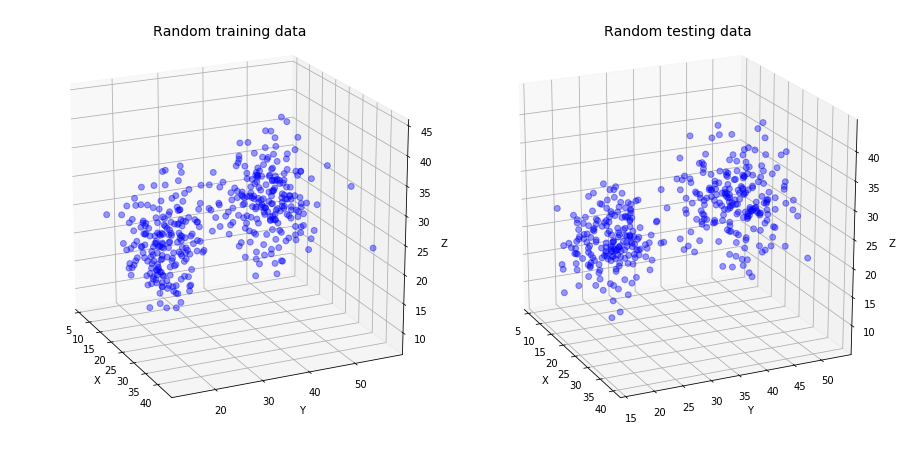

In [0]:
#@markdown - **显示训练，测试数据的分布**
titles = ['Random training data', 'Random testing data']
DATA = [data.sample, data_t.sample]
fig = plt.figure(1, figsize=(16, 8))
fig.subplots_adjust(wspace=.01, hspace=.02)
for i, title, data_n in zip([1, 2], titles, DATA):
	ax = fig.add_subplot(1, 2, i, projection='3d')
	ax.scatter(data_n[:,0], data_n[:,1], data_n[:,2], c='b', s=35, alpha=0.4, marker='o')
	ax.set_xlabel('X')
	ax.set_ylabel('Y')
	ax.set_zlabel('Z')
	ax.view_init(elev=20., azim=-25)
	ax.set_title(title, fontsize=14)
plt.show()

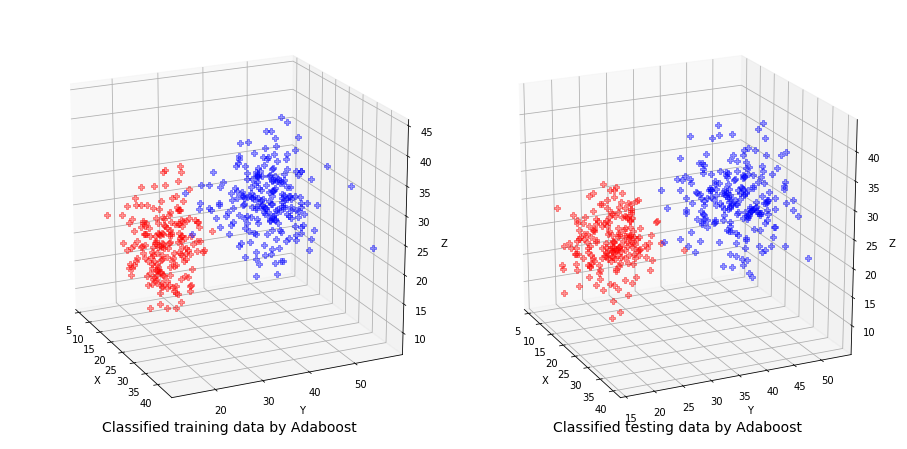

In [0]:
#@markdown - **显示 Adaboost 对训练，测试数据的分类情况**
titles = ['Classified training data by Adaboost', 'Classified testing data by Adaboost']
TAR = [tar_train, tar_test]
fig = plt.figure(2, figsize=(16, 8))
fig.subplots_adjust(wspace=.01, hspace=.02)
for i, title, data_n, tar in zip([1, 2], titles, DATA, TAR):
    ax = fig.add_subplot(1, 2, i, projection='3d')
    color=['b','g', 'r']
    for j in range(N):
        ax.scatter(data_n[j, 0], data_n[j, 1], data_n[j, 2], c=color[tar[j]], s=35, alpha=0.4, marker='P')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.view_init(elev=20., azim=-25)
        ax.set_title(title, fontsize=14, y=0.01)
plt.show()